## Punctate metric is biasing genes with fewer spots per cell to have more punctate scores

Same issue with radial metric

Definitely occuring when the number of spots, m = 1

Not sure actually if this is occuring when m > 1, but I'll test that now

I've added a method to the Cell class to filter out genes with counts below a threshold

In [45]:
import importlib
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import SRRS
from SRRS import scoring, metrics, plotting, simulate

In [46]:
#Cells have already had their genes filtered out if there were only 1 spot
sample = SRRS.HDF5('temp_cells.hdf5')
#sample = SRRS.HDF5('../inputs/m1s1_subset.hdf5')
cells = sample.get_cells_by_id(['145531913712168956084196484724954151860'])


cell = cells[0]

#score the cell
cell = list(scoring._iter_scores([cell], metric_name='punctate'))[0]

In [4]:
plotting.plot_cell_3D?

In [10]:
num_genes = len(cell.genes)
colors = sns.color_palette('viridis',num_genes)
gene_colors = {g:c for g,c in zip(cell.genes,colors)}

In [25]:
pd.DataFrame(cell.gene_counts.items(),columns=['gene','spot_counts']).sort_values('spot_counts').reset_index(drop=True)

,gene,spot_counts
0,Myh14,2
1,Fezf2,2
2,Timp3,2
3,Ramp1,2
4,Plch1,2
...,...,...
67,Sulf2,26
68,Col25a1,28
69,Rorb,31
70,Satb2,34


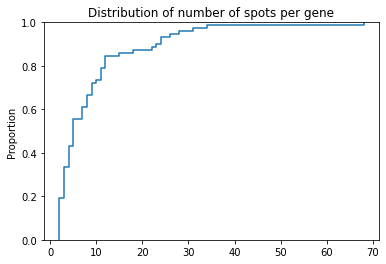

In [27]:
sns.ecdfplot(
    x = cell.gene_counts.values(),
)
plt.title('Distribution of number of spots per gene')
plt.show()
plt.close()

In [17]:
cell.n

642

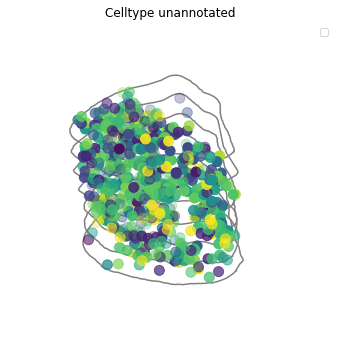

In [16]:
fig,ax = plotting.plot_cell_3D(cell, gene_colors=gene_colors)
plt.legend([])
plt.show()
plt.close()

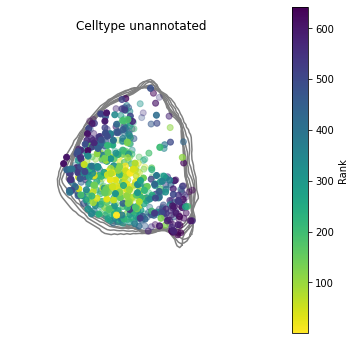

In [36]:
cell = next(scoring._iter_scores([cell], metric_name='peripheral'))

fig,ax = plotting.plot_cell_3D(cell, color_by_rank=True)
ax.elev = 90
plt.show()
plt.close()

In [40]:
num_sims = 1000
data = {
    'iteration':[],
    'num_gene_spots':[],
    'score':[],
    'theory_variance':[],
}

gene_count_min_rank = []

for i in range(num_sims):
    if i%100 == 0:
        print(i)
        
    #permute the gene labels of the cell in place (completely uniform permute)
    cell = simulate.null_permute_gene_labels(cell, within_z = False)
    cell.ranked = False #force re-scoring
    
    found_rank_one = False
    for z in cell.zslices:
        for g,r in zip(cell.spot_genes[z],cell.spot_ranks[z]):
            if r == 1:
                gene_count_min_rank.append(cell.gene_counts[g])
                break

        if found_rank_one:
            break

    score_df = pd.concat(scoring.iter_scores([cell], metric='punctate'))
    
    data['iteration'].extend([i]*len(score_df))
    data['score'].extend(score_df['score'].values)
    data['num_gene_spots'].extend(score_df['num_gene_spots'].values)
    data['theory_variance'].extend(score_df['variance'].values)

    #plotting.plot_cell_3D(cell, gene_colors={'Fezf2':'red'}) #This gene only has two spots
    #plt.show()
    #plt.close()
    
sim_df = pd.DataFrame(data)
sim_df

0
100
200
300
400
500
600
700
800
900


,iteration,num_gene_spots,score,theory_variance
0,0,11,0.354134,0.075959
1,0,26,-0.003120,0.033153
2,0,9,-0.273011,0.090055
3,0,23,0.235569,0.038748
4,0,7,0.266771,0.110415
...,...,...,...,...
71995,999,2,0.873635,0.166926
71996,999,3,0.659906,0.199998
71997,999,2,-0.402496,0.166926
71998,999,8,-0.354134,0.088192


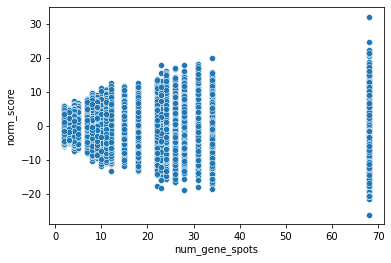

In [39]:
sim_df['norm_score'] = sim_df['score'].div(sim_df['theory_variance'])

sns.scatterplot(
    x = 'num_gene_spots',
    y = 'norm_score',
    data = sim_df,
)
plt.show()
plt.close()

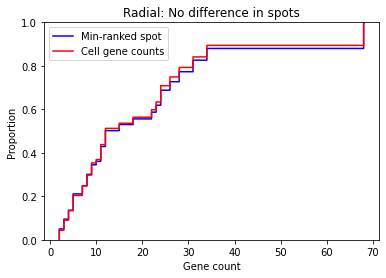

In [252]:
sns.ecdfplot(
    gene_count_min_rank,
    color = 'blue',
    label = 'Min-ranked spot',
)

background = []
for v in cell.gene_counts.values():
    background.extend([v]*v)
    
sns.ecdfplot(
    background,
    color = 'red',
    label = 'Cell gene counts',
)
plt.legend()
plt.xlabel('Gene count')
plt.title('Radial: No difference in spots')
plt.show()
plt.close()

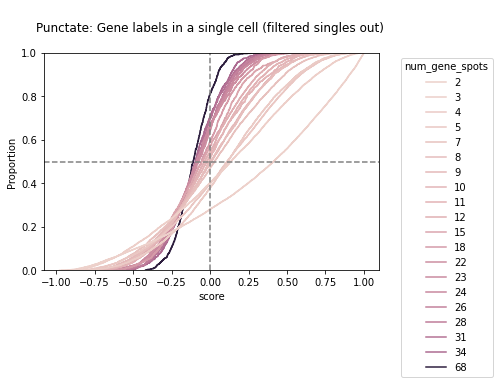

In [41]:
ax = sns.ecdfplot(
    x = 'score',
    hue = 'num_gene_spots',
    data = sim_df,
)
sns.move_legend(ax, loc=2, bbox_to_anchor=(1.05, 1))
plt.axhline(0.5, linestyle='dashed', color='grey')
plt.axvline(0, linestyle='dashed', color='grey')
plt.title("""
Punctate: Gene labels in a single cell (filtered singles out) 
""")
plt.show()
plt.close()

12   -0.322933
Name: score, dtype: float64


,metric,cell_id,annotation,num_spots,gene,num_gene_spots,median_rank,score,variance
30,punctate,145531913712168956084196484724954151860,unannotated,642,Itgb8,2,23.5,0.929797,0.166926
65,punctate,145531913712168956084196484724954151860,unannotated,642,Pdgfc,2,44.5,0.864275,0.166926
68,punctate,145531913712168956084196484724954151860,unannotated,642,Sox6,3,51.0,0.843994,0.199998
26,punctate,145531913712168956084196484724954151860,unannotated,642,Grm8,7,72.0,0.778471,0.110415
32,punctate,145531913712168956084196484724954151860,unannotated,642,March1,4,111.0,0.656786,0.133123


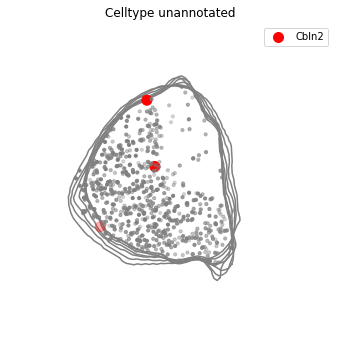

12    0.098284
Name: score, dtype: float64


,metric,cell_id,annotation,num_spots,gene,num_gene_spots,median_rank,score,variance
23,punctate,145531913712168956084196484724954151860,unannotated,642,Sox10,4,67.5,0.792512,0.133123
63,punctate,145531913712168956084196484724954151860,unannotated,642,Blnk,2,85.5,0.736349,0.166926
46,punctate,145531913712168956084196484724954151860,unannotated,642,Dscaml1,5,92.0,0.716069,0.142409
16,punctate,145531913712168956084196484724954151860,unannotated,642,Luzp2,3,110.0,0.659906,0.199998
62,punctate,145531913712168956084196484724954151860,unannotated,642,Blank-3,2,112.5,0.652106,0.166926


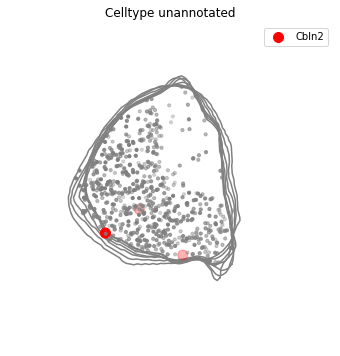

12   -0.088924
Name: score, dtype: float64


,metric,cell_id,annotation,num_spots,gene,num_gene_spots,median_rank,score,variance
30,punctate,145531913712168956084196484724954151860,unannotated,642,Itgb8,2,7.5,0.979719,0.166926
54,punctate,145531913712168956084196484724954151860,unannotated,642,Timp3,2,27.5,0.917317,0.166926
63,punctate,145531913712168956084196484724954151860,unannotated,642,Blnk,2,30.5,0.907956,0.166926
27,punctate,145531913712168956084196484724954151860,unannotated,642,Tox,3,52.0,0.840874,0.199998
47,punctate,145531913712168956084196484724954151860,unannotated,642,Ntng2,3,104.0,0.678627,0.199998


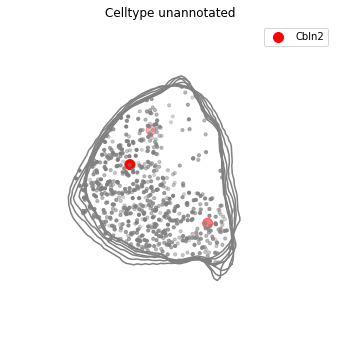

12    0.463339
Name: score, dtype: float64


,metric,cell_id,annotation,num_spots,gene,num_gene_spots,median_rank,score,variance
58,punctate,145531913712168956084196484724954151860,unannotated,642,Fam19a2,2,7.5,0.979719,0.166926
29,punctate,145531913712168956084196484724954151860,unannotated,642,Plch1,2,12.5,0.964119,0.166926
50,punctate,145531913712168956084196484724954151860,unannotated,642,Ramp1,2,15.5,0.954758,0.166926
30,punctate,145531913712168956084196484724954151860,unannotated,642,Itgb8,2,44.5,0.864275,0.166926
62,punctate,145531913712168956084196484724954151860,unannotated,642,Blank-3,2,60.5,0.814353,0.166926


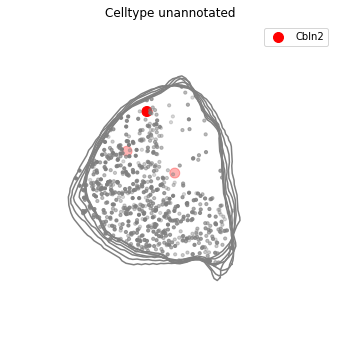

12   -0.382215
Name: score, dtype: float64


,metric,cell_id,annotation,num_spots,gene,num_gene_spots,median_rank,score,variance
18,punctate,145531913712168956084196484724954151860,unannotated,642,Tshz2,2,13.5,0.960998,0.166926
56,punctate,145531913712168956084196484724954151860,unannotated,642,Trp53i11,4,28.0,0.915757,0.133123
62,punctate,145531913712168956084196484724954151860,unannotated,642,Blank-3,2,65.5,0.798752,0.166926
40,punctate,145531913712168956084196484724954151860,unannotated,642,Grin3a,4,88.5,0.726989,0.133123
27,punctate,145531913712168956084196484724954151860,unannotated,642,Tox,3,129.0,0.600624,0.199998


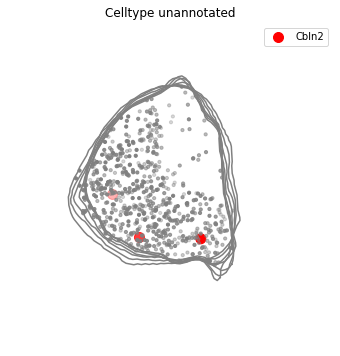

12    0.659906
Name: score, dtype: float64


,metric,cell_id,annotation,num_spots,gene,num_gene_spots,median_rank,score,variance
67,punctate,145531913712168956084196484724954151860,unannotated,642,Sema5a,2,8.5,0.976599,0.166926
50,punctate,145531913712168956084196484724954151860,unannotated,642,Ramp1,2,11.5,0.967239,0.166926
30,punctate,145531913712168956084196484724954151860,unannotated,642,Itgb8,2,16.5,0.951638,0.166926
14,punctate,145531913712168956084196484724954151860,unannotated,642,Fezf2,2,50.5,0.845554,0.166926
16,punctate,145531913712168956084196484724954151860,unannotated,642,Luzp2,3,69.0,0.787832,0.199998


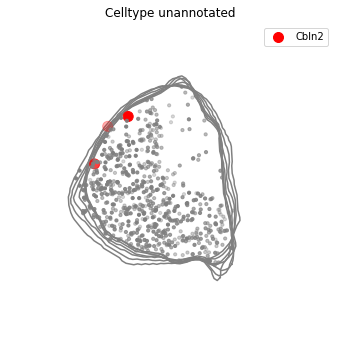

12   -0.129485
Name: score, dtype: float64


,metric,cell_id,annotation,num_spots,gene,num_gene_spots,median_rank,score,variance
30,punctate,145531913712168956084196484724954151860,unannotated,642,Itgb8,2,6.5,0.982839,0.166926
69,punctate,145531913712168956084196484724954151860,unannotated,642,Aqp4,2,14.5,0.957878,0.166926
18,punctate,145531913712168956084196484724954151860,unannotated,642,Tshz2,2,21.5,0.936037,0.166926
64,punctate,145531913712168956084196484724954151860,unannotated,642,Chn2,2,51.5,0.842434,0.166926
29,punctate,145531913712168956084196484724954151860,unannotated,642,Plch1,2,54.5,0.833073,0.166926


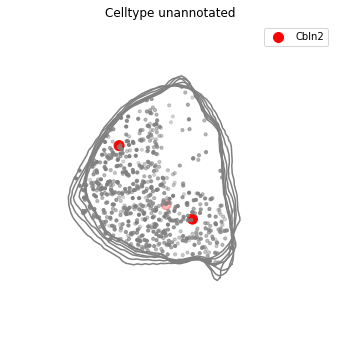

12   -0.070203
Name: score, dtype: float64


,metric,cell_id,annotation,num_spots,gene,num_gene_spots,median_rank,score,variance
62,punctate,145531913712168956084196484724954151860,unannotated,642,Blank-3,2,5.5,0.985959,0.166926
14,punctate,145531913712168956084196484724954151860,unannotated,642,Fezf2,2,34.5,0.895476,0.166926
68,punctate,145531913712168956084196484724954151860,unannotated,642,Sox6,3,43.0,0.868955,0.199998
63,punctate,145531913712168956084196484724954151860,unannotated,642,Blnk,2,77.5,0.761310,0.166926
29,punctate,145531913712168956084196484724954151860,unannotated,642,Plch1,2,79.5,0.755070,0.166926


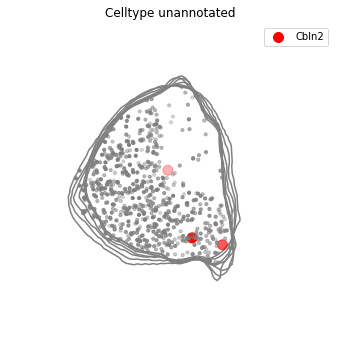

12   -0.082683
Name: score, dtype: float64


,metric,cell_id,annotation,num_spots,gene,num_gene_spots,median_rank,score,variance
50,punctate,145531913712168956084196484724954151860,unannotated,642,Ramp1,2,9.5,0.973479,0.166926
29,punctate,145531913712168956084196484724954151860,unannotated,642,Plch1,2,13.5,0.960998,0.166926
14,punctate,145531913712168956084196484724954151860,unannotated,642,Fezf2,2,19.5,0.942278,0.166926
69,punctate,145531913712168956084196484724954151860,unannotated,642,Aqp4,2,80.5,0.751950,0.166926
39,punctate,145531913712168956084196484724954151860,unannotated,642,Rfx3,5,84.0,0.741030,0.142409


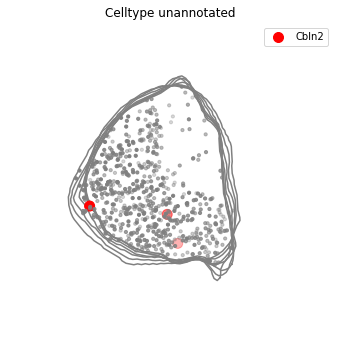

12    0.388456
Name: score, dtype: float64


,metric,cell_id,annotation,num_spots,gene,num_gene_spots,median_rank,score,variance
64,punctate,145531913712168956084196484724954151860,unannotated,642,Chn2,2,26.5,0.920437,0.166926
14,punctate,145531913712168956084196484724954151860,unannotated,642,Fezf2,2,34.5,0.895476,0.166926
50,punctate,145531913712168956084196484724954151860,unannotated,642,Ramp1,2,79.5,0.755070,0.166926
18,punctate,145531913712168956084196484724954151860,unannotated,642,Tshz2,2,107.5,0.667707,0.166926
54,punctate,145531913712168956084196484724954151860,unannotated,642,Timp3,2,121.5,0.624025,0.166926


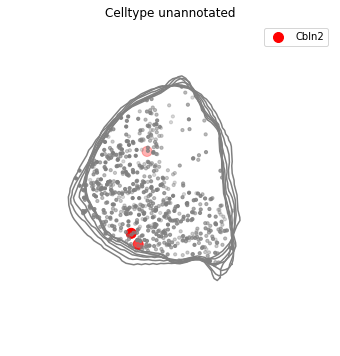

In [125]:
num_sims = 10


for i in range(num_sims):
        
    #permute the gene labels of the cell in place (completely uniform permute)
    cell = simulate.null_permute_gene_labels(cell, within_z = False)
    cell.ranked = False #force re-scoring

    score_df = pd.concat(scoring.iter_scores([cell], metric='punctate'))
    print(score_df[score_df['gene'].eq('Cbln2')]['score'])
    display(score_df.sort_values('score',ascending=False).head())
    
    fig,ax = plotting.plot_cell_3D(cell, gene_colors={'Cbln2':'red'}) #This gene only has two spots
    ax.elev = 90
    plt.show()
    plt.close()
    


{'0': ['Col25a1',
  'Prr16',
  'St6galnac5',
  'C1ql3',
  'Ptprt',
  'Sertm1',
  'Rorb',
  'Grin3a',
  'Prr16',
  'Ptprt',
  'Phactr2',
  'Ptprt',
  'Shisa9',
  'Col25a1',
  'Prdm8',
  'Shisa9',
  'Flrt3',
  'Rorb',
  'Rfx3',
  'C1ql3',
  'Ptprk',
  'Camk2d',
  'Tshz2',
  'Col25a1',
  'Unc5d',
  'Syndig1',
  'Thbs2',
  'Ptprk',
  'Flrt3',
  'Igfbp5',
  'Ccdc3',
  'Luzp2',
  'Ptprk',
  'Slc30a3',
  'Wipf3',
  'Rorb',
  'Rorb',
  'Slc30a3',
  'Ntng2',
  'Thsd7a',
  'Satb2',
  'Pou3f3',
  'Pou3f3',
  'Pou3f3',
  'Cux2',
  'Cdh12'],
 '1': ['Ctss',
  'Ptprt',
  'Satb2',
  'Sox6',
  'Satb2',
  'March1',
  'Rorb',
  'Rgs6',
  'Cux2',
  'Pld5',
  'Sulf2',
  'Igfbp5',
  'C1ql3',
  'Pou3f3',
  'C1ql3',
  'Satb2',
  'Camk2d',
  'Plch1',
  'Sulf2',
  'Cntnap5b',
  'Wnt7b',
  'Marcksl1',
  'Thbs2',
  'Col25a1',
  'Prdm8',
  'Rorb',
  'Aqp4',
  'Rfx3',
  'Trpc4',
  'Col25a1',
  'Slc30a3',
  'Rorb',
  'Camk2d',
  'Ctss',
  'Sulf2',
  'Trpc4',
  'Ankfn1',
  'Ccdc3',
  'Grin3a',
  'Nr4a1',
  'Rorb',
  

In [119]:
spot_rank_data = {
    'gene':[],
    'rank':[],
    'gene_counts':[],
}
for z in cell.zslices:
    for g,r in zip(cell.spot_genes[z], cell.spot_ranks[z]):
        spot_rank_data['gene'].append(g)
        spot_rank_data['rank'].append(r)
        spot_rank_data['gene_counts'].append(cell.gene_counts[g])

spot_rank_df = pd.DataFrame(spot_rank_data).sort_values('rank')
spot_rank_df

,gene,rank,gene_counts
563,Prdm8,1,22
595,C1ql3,2,24
253,Shisa9,3,18
596,Pld5,4,8
428,Rorb,5,31
...,...,...,...
173,Wipf3,638,12
323,Cntnap5b,639,5
320,Igfbp5,640,12
13,Col25a1,641,28


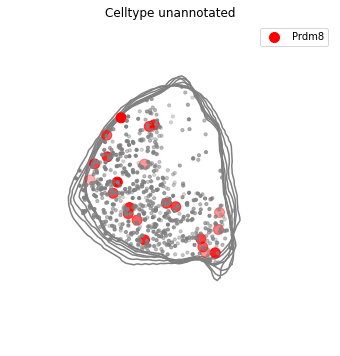

In [121]:
fig,ax = plotting.plot_cell_3D(cell, gene_colors={'Prdm8':'red'})
ax.elev = 90
plt.show()
plt.close()

In [123]:
spot_rank_df[spot_rank_df['gene'].eq('Cntnap5b')]

,gene,rank,gene_counts
529,Cntnap5b,22,5
209,Cntnap5b,270,5
65,Cntnap5b,399,5
367,Cntnap5b,539,5
323,Cntnap5b,639,5


In [20]:
%%time

#slow since gene_vars need to be recalculated
min_gene_spots = 2
filt_cells = [c.filter_low_count_genes(min_gene_spots) for c in sample.iter_cells()] #remove gene spots
filt_cells = [c for c in filt_cells if c.n > 300] #remove cells with too few spots

filt_cells = list(scoring._iter_vars(filt_cells)    )
filt_scored_cells = list(scoring._iter_scores(filt_cells, metric_name='punctate', processes=3))

len(filt_scored_cells)

CPU times: user 2.73 s, sys: 112 ms, total: 2.85 s
Wall time: 1min 37s


68

In [21]:
SRRS.HDF5.write_cells(filt_cells, 'temp_cells.hdf5')

In [6]:
cell

Cell-104887114217211410540888577620028568901-L45_IT_1

In [9]:
cell.zslices

['0', '1', '2', '3', '4', '5', '6']

In [10]:
cell.spot_coords

{'0': [array([-4699.28  ,  1225.7178]),
  array([-4698.545 ,  1223.9531]),
  array([-4698.048,  1224.627]),
  array([-4697.728 ,  1224.8693]),
  array([-4697.221 ,  1225.7792]),
  array([-4694.898 ,  1223.8654]),
  array([-4694.345 ,  1225.3196]),
  array([-4693.663 ,  1224.8531]),
  array([-4693.495 ,  1219.5729]),
  array([-4693.1797,  1226.0217]),
  array([-4693.078 ,  1220.4568]),
  array([-4692.769 ,  1220.1185]),
  array([-4692.693 ,  1220.3354]),
  array([-4691.582 ,  1222.8816]),
  array([-4691.2095,  1223.7832]),
  array([-4690.9814,  1219.7634]),
  array([-4690.718 ,  1222.9454]),
  array([-4690.2446,  1218.5995]),
  array([-4690.148 ,  1218.3606]),
  array([-4690.083 ,  1225.1095]),
  array([-4690.005 ,  1219.1725]),
  array([-4689.9414,  1223.6824]),
  array([-4689.6973,  1225.0088]),
  array([-4689.655 ,  1226.4641]),
  array([-4689.393 ,  1218.7181]),
  array([-4689.3174,  1221.9325]),
  array([-4689.264 ,  1217.3573]),
  array([-4689.0522,  1216.988 ]),
  array([-4688.70

In [24]:
cell.zslices

['0', '1', '2', '3', '4', '5', '6']

In [4]:
#get median gene ranks for each cell
pd.concat(scoring.iter_scores(filt_scored_cells, metric='punctate'))

,metric,cell_id,annotation,num_spots,gene,num_gene_spots,median_rank,score,variance
0,punctate,104887114217211410540888577620028568901,L45_IT_1,467,Slc30a3,56,203.0,0.133047,0.015004
1,punctate,104887114217211410540888577620028568901,L45_IT_1,467,Rorb,26,247.0,-0.055794,0.032686
2,punctate,104887114217211410540888577620028568901,L45_IT_1,467,Cdh12,10,184.0,0.214592,0.074613
3,punctate,104887114217211410540888577620028568901,L45_IT_1,467,Thsd7a,4,162.5,0.306867,0.133044
4,punctate,104887114217211410540888577620028568901,L45_IT_1,467,Ptprt,19,269.5,-0.152361,0.045976
...,...,...,...,...,...,...,...,...,...
61,punctate,98094925393968329130254909503130262661,L5_IT_2,770,Rgs5,4,426.5,-0.106632,0.133159
62,punctate,98094925393968329130254909503130262661,L5_IT_2,770,Sgcd,2,217.0,0.438231,0.166883
63,punctate,98094925393968329130254909503130262661,L5_IT_2,770,Cntnap5b,4,208.0,0.461638,0.133159
64,punctate,98094925393968329130254909503130262661,L5_IT_2,770,Sertm1,2,207.5,0.462939,0.166883


In [5]:
#get per spot per cell ranks instead
data = {
    'filtering':[],
    'cell_id':[],
    'gene':[],
    'rank':[],
    'm':[],
    'n':[],
}

for filtering,cells in (('filt',filt_scored_cells),('unfilt',unfilt_scored_cells)):
    for cell in cells:
        for z in cell.zslices:
            for g,r in zip(cell.spot_genes[z], cell.spot_ranks[z]):
                data['filtering'].append(filtering)
                data['cell_id'].append(cell.cell_id)
                data['gene'].append(g)
                data['rank'].append(r)
                data['m'].append(cell.gene_counts[g])
                data['n'].append(cell.n)
            
spot_ranks = pd.DataFrame(data)
spot_ranks  

,filtering,cell_id,gene,rank,m,n
0,filt,104773525917171323315032845506736864421,Cdh12,152,12,288
1,filt,104773525917171323315032845506736864421,Rorb,214,18,288
2,filt,104773525917171323315032845506736864421,Prdm8,155,7,288
3,filt,104773525917171323315032845506736864421,Cdh12,99,12,288
4,filt,104773525917171323315032845506736864421,Lsp1,15,2,288
...,...,...,...,...,...,...
81958,unfilt,98094925393968329130254909503130262661,Marcksl1,767,26,818
81959,unfilt,98094925393968329130254909503130262661,C1ql3,158,47,818
81960,unfilt,98094925393968329130254909503130262661,Sulf2,109,37,818
81961,unfilt,98094925393968329130254909503130262661,Shisa9,405,19,818


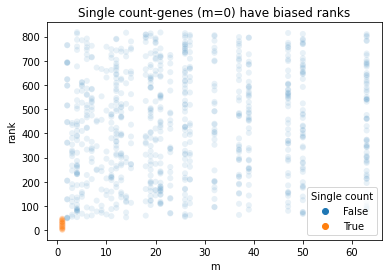

In [9]:
plot_df = spot_ranks[
    spot_ranks['filtering'].eq('unfilt') &
    spot_ranks['cell_id'].eq('98094925393968329130254909503130262661')
].copy()
plot_df['Single count'] = plot_df['m'].eq(1)

ax = sns.scatterplot(
    x = 'm',
    y = 'rank',
    alpha = 0.1,
    hue = 'Single count',
    data = plot_df,
)
ax.set_title('Unfiltered, Single count-genes (m=0) have biased ranks')
plt.show()
plt.close()

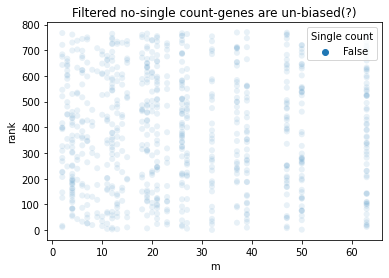

In [12]:
plot_df = spot_ranks[
    spot_ranks['filtering'].eq('filt') &
    spot_ranks['cell_id'].eq('98094925393968329130254909503130262661')
].copy()
plot_df['Single count'] = plot_df['m'].eq(1)

ax = sns.scatterplot(
    x = 'm',
    y = 'rank',
    alpha = 0.1,
    hue = 'Single count',
    data = plot_df,
)
ax.set_title('Filtered no-single count-genes are un-biased(?)')
plt.show()
plt.close()

# Formalizing test for punctate bias by gene-count

Now that I've applied the filtering, I can visually see that the bias might be removed

But how can I quantitatively be sure?

I'm going to start by plotting punctate score vs gene/fraction from all cells and see if it "looks correct"

In [62]:
score_df = pd.concat(scoring.iter_scores(filt_scored_cells, metric='radial'),ignore_index=True)
score_df

,metric,cell_id,annotation,num_spots,gene,num_gene_spots,median_rank,score,variance
0,radial,104773525917171323315032845506736864421,L45_IT_1,288,Cdh12,12,144.0,0.003484,0.063849
1,radial,104773525917171323315032845506736864421,L45_IT_1,288,Rorb,18,85.0,0.414634,0.044873
2,radial,104773525917171323315032845506736864421,L45_IT_1,288,Prdm8,7,61.0,0.581882,0.109546
3,radial,104773525917171323315032845506736864421,L45_IT_1,288,Lsp1,2,110.5,0.236934,0.167243
4,radial,104773525917171323315032845506736864421,L45_IT_1,288,Nr4a1,7,128.5,0.111498,0.109546
...,...,...,...,...,...,...,...,...,...
4394,radial,98094925393968329130254909503130262661,L5_IT_2,770,Rgs5,4,519.5,-0.348505,0.133159
4395,radial,98094925393968329130254909503130262661,L5_IT_2,770,Sgcd,2,108.5,0.720416,0.166883
4396,radial,98094925393968329130254909503130262661,L5_IT_2,770,Cntnap5b,4,627.0,-0.628088,0.133159
4397,radial,98094925393968329130254909503130262661,L5_IT_2,770,Sertm1,2,166.5,0.569571,0.166883


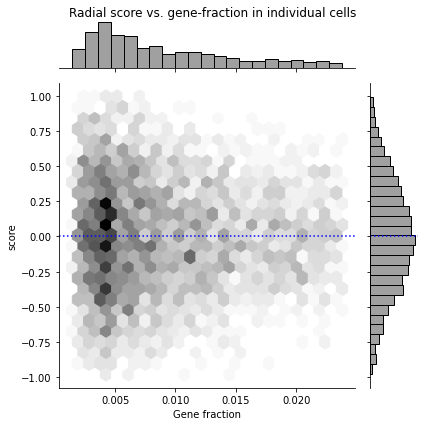

In [63]:
score_df['Gene fraction'] = score_df['num_gene_spots'].div(score_df['num_spots'])
max_frac = score_df['Gene fraction'].quantile(0.8)

p = sns.jointplot(
    x = 'Gene fraction',
    y = 'score',
    kind = 'hex',
    color = 'grey',
    data = score_df[score_df['Gene fraction'].le(max_frac)],
)

p.ax_joint.axhline(0,linestyle='dotted',color='blue')
p.ax_marg_y.axhline(0,linestyle='dotted',color='blue')

#p.ax_joint.set_xlim(0,max_frac)

p.fig.suptitle('Radial score vs. gene-fraction in individual cells')
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95) # Reduce plot to make room #got code from https://stackoverflow.com/questions/60358228/how-to-set-title-on-seaborn-jointplot

plt.show()
plt.close()

the plot does "look" correct, but maybe I can visualize in a different way by binning the gene fractions and plotting CDFs

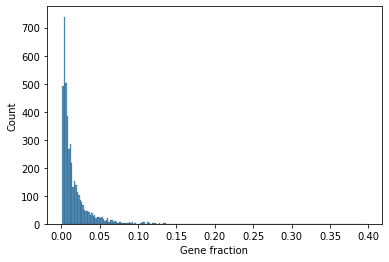

In [44]:
sns.histplot(score_df['Gene fraction'])
plt.show()
plt.close()

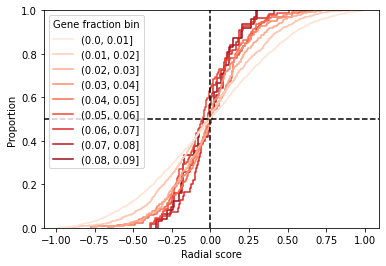

In [65]:
bins = np.arange(0,0.1,0.01)

score_df['Gene fraction bin'] = pd.cut(score_df['Gene fraction'], bins=bins)
ax = sns.ecdfplot(
    x = 'score',
    hue = 'Gene fraction bin',
    palette = 'Reds',
    data = score_df,
)
ax.axhline(0.5, linestyle='dashed', color='black')
ax.axvline(0.0, linestyle='dashed', color='black')
plt.xlabel('Radial score')
plt.show()
plt.close()

# New punctate metric measuring from multiple points in space

In [47]:
import importlib
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import SRRS
from SRRS import scoring, metrics, plotting, simulate, utils

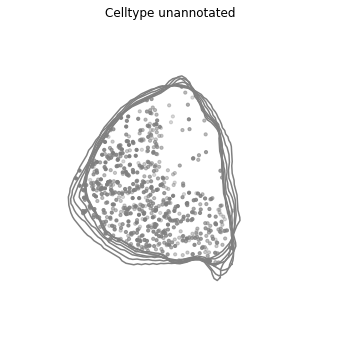

In [48]:
#Cells have already had their genes filtered out if there were only 1 spot
sample = SRRS.HDF5('temp_cells.hdf5')
cells = sample.get_cells_by_id(['145531913712168956084196484724954151860']) #my new favorite cell


cell = cells[0]

fig,ax = plotting.plot_cell_3D(cell)
ax.elev = 90
plt.show()
plt.close()

,gene,obs_var,theory_var,gene_spots
0,Adra1b,0.081971,0.075959,11
1,Ankfn1,0.189770,0.142409,5
2,Aqp4,0.043804,0.166926,2
3,Blank-3,0.011722,0.166926,2
4,Blnk,0.298502,0.166926,2
...,...,...,...,...
67,Tshz2,0.236532,0.166926,2
68,Unc5d,0.044490,0.075959,11
69,Vtn,0.188267,0.133123,4
70,Wipf3,0.249131,0.065005,12


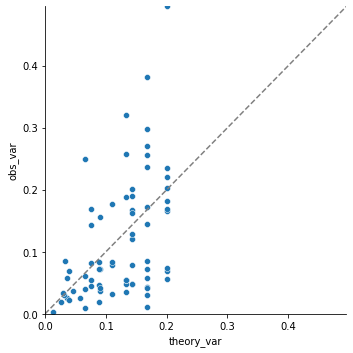

In [49]:
def _spot_dist_and_rank(cell,ref_spot):
    """
    Helper function to calculate ranks from a reference spot
    """

    #calculate distance of spot coords to cell centroid
    spot_genes = []
    spot_dists = []
    for zslice in cell.zslices:
        z_spot_coords = cell.spot_coords[zslice]
        z_spot_genes = cell.spot_genes[zslice]

        #Euclidean distance to reference x,y spot
        dists = np.sum((z_spot_coords-ref_spot)**2, axis=1)
        spot_genes.extend(z_spot_genes)
        spot_dists.extend(dists)

    #Rank the spots
    spot_genes = np.array(spot_genes)
    spot_ranks = np.array(spot_dists).argsort().argsort()+1 #add one so ranks start at 1 rather than 0

    #save the ranks back to the cell object by z-slice
    start_i = 0
    for zslice in cell.zslices:
        end_i = cell.n_per_z[zslice]+start_i
        cell.spot_ranks[zslice] = spot_ranks[start_i:end_i]
        cell.spot_values[zslice] = spot_dists[start_i:end_i]
        start_i = end_i

    return cell


def multispot_proximity(cell, num_rows=3, num_cols=3):
    
    #get the boundary coordinates
    min_x,min_y,max_x,max_y = None,None,None,None
    for z,boundary_coords in cell.boundaries.items():
        z_min_x,z_min_y = boundary_coords.min(axis=0)
        z_max_x,z_max_y = boundary_coords.max(axis=0)
        
        if not min_x or z_min_x < min_x:
            min_x = z_min_x
        if not min_y or z_min_y < min_y:
            min_y = z_min_y
        if not max_x or z_max_x > max_x:
            max_x = z_max_x
        if not max_y or z_max_y > max_y:
            max_y = z_max_y
        
    #get the x,y grid points to measure from
    x_spacing = (max_x-min_x)/(num_rows+1)
    y_spacing = (max_y-min_y)/(num_cols+1)
    
    grid_points = []
    for i in range(num_rows):
        for j in range(num_cols):
            x = (i+1)*x_spacing+min_x
            y = (j+1)*y_spacing+min_y
            grid_points.append((x,y))
    
    grid_points = np.array(grid_points)
    
    #perform the ranking and scoring for each grid point
    all_scores = pd.DataFrame()
    for i in range(num_rows*num_cols):
        cell.ranked = False
        ranked_cell = _spot_dist_and_rank(cell,grid_points[i])
        ranked_cell = metrics._update_med_ranks(ranked_cell)
        
        scores = [(g,utils.score(r,cell.n)) for g,r in ranked_cell.gene_med_ranks.items()]
        scores_df = pd.DataFrame(scores,columns=['gene','score'])
        scores_df['ref_point'] = i
        all_scores = pd.concat((all_scores,scores_df))
        
    
    return all_scores,grid_points


        
nrows,ncols = 10,10
scores,grid_points = multispot_proximity(cell, nrows, ncols)

agg_scores = scores.groupby('gene')['score'].var().reset_index(name='obs_var')
agg_scores['theory_var'] = agg_scores['gene'].map(cell.gene_vars)
agg_scores['gene_spots'] = agg_scores['gene'].map(cell.gene_counts)
display(agg_scores)

sns.relplot(
    x = 'theory_var',
    y = 'obs_var',
    data = agg_scores,
)

max_val = agg_scores[['obs_var','theory_var']].max().max()
plt.xlim(0,max_val)
plt.ylim(0,max_val)
plt.plot([0,max_val],[0,max_val],color='grey',linestyle='dashed')
plt.show()
plt.close()

AttributeError: module 'matplotlib.pyplot' has no attribute 'scatter3D'

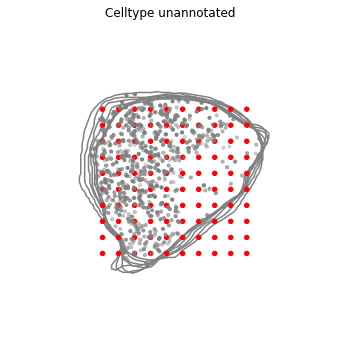

In [57]:
fig,ax = plotting.plot_cell_3D(cell)
ax.azim = 0
ax.elev = 90
ax.scatter(xs=grid_points[:,0], ys=grid_points[:,1], zs=[0]*grid_points.shape[0],color='red')
plt.show()
plt.close()